In [1]:
import polars as pl
import bids
import seaborn as sns
data_dir = "/Users/morton/Downloads/ds004117"

In [2]:
def clean_data(data, subject, run):
    probe_roles = ["probe_target", "probe_not_shown"]
    response_roles = [
        "remembered_correct", 
        "ignored_correct", 
        "remembered_incorrect",
        "ignored_incorrect",
    ]
    trials = (
        data.filter(
            (pl.col("task_role").is_in(probe_roles + response_roles))
            & (pl.col("trial") > 0)
            & ((~(pl.col("task_role") == "bad_trial").any()).over(pl.col("trial")))
        )
        .with_columns(
            pl.when(pl.col("event_type") == "show_letter")
            .then(pl.lit("probe"))
            .otherwise(pl.lit("feedback"))
            .alias("trial_type"),
            (pl.col("onset").max() - pl.col("onset").min()).over(pl.col("trial")).alias("response_time"),
            set_size=pl.col("memory_cond"),
        )
        .pivot("trial_type", on_columns=["probe", "feedback"], index=["trial", "set_size", "response_time"], values="task_role")
        .with_columns(
            pl.col("probe").replace({"probe_target": "target", "probe_not_shown": "lure"}),
            pl.when(pl.col("feedback").str.starts_with("remembered"))
            .then(pl.lit("old"))
            .otherwise(
                pl.when(pl.col("feedback").str.starts_with("ignored"))
                .then(pl.lit("new"))
                .otherwise(None)
            )
            .alias("response"),
            pl.when(pl.col("feedback").str.ends_with("correct"))
            .then(1)
            .otherwise(
                pl.when(pl.col("feedback").str.ends_with("incorrect"))
                .then(0)
                .otherwise(None)
            )
            .alias("correct"),
            subject=pl.lit(subject),
            run=run,
        )
        .select(["subject", "run", "trial", "set_size", "probe", "response", "correct", "response_time"])
    )
    return trials

In [3]:
layout = bids.BIDSLayout(data_dir)
files = layout.get(suffix="events", extension="tsv")
all_data = []
for file in files:
    subject = file.entities["subject"]
    run = file.entities["run"]
    raw = pl.read_csv(file.path, separator="\t")
    try:
        run_data = clean_data(raw, subject, run)
    except:
        print(subject, run)
    all_data.append(run_data)
data = pl.concat(all_data, how="vertical")

In [4]:
data.write_csv("Onton2005.tsv", separator="\t", null_value="n/a")
data

subject,run,trial,set_size,probe,response,correct,response_time
str,i32,i64,i64,str,str,i32,f64
"""001""",1,1,3,"""target""","""old""",1,1.358005
"""001""",1,2,7,"""lure""","""new""",1,1.081504
"""001""",1,3,3,"""target""","""old""",1,1.102704
"""001""",1,4,7,"""target""","""old""",1,1.086204
"""001""",1,5,7,"""lure""","""new""",1,1.398406
…,…,…,…,…,…,…,…
"""024""",3,21,3,"""lure""","""new""",1,1.151093
"""024""",3,22,3,"""target""","""new""",1,0.718383
"""024""",3,23,3,"""lure""","""new""",1,0.86522


In [5]:
rt = (
    data.filter(pl.col("correct") == 1)
    .group_by("subject", "set_size", "probe")
    .agg(pl.col("response_time").mean())
)

In [6]:
(
    rt.group_by("set_size", "probe")
    .agg(
        mean=pl.col("response_time").mean(),
        sd=pl.col("response_time").std(),
    )
    .sort("probe", "set_size")
)

set_size,probe,mean,sd
i64,str,f64,f64
3,"""lure""",1.03478,0.268056
5,"""lure""",1.201804,0.427878
7,"""lure""",1.315073,0.496336
3,"""target""",0.985542,0.219236
5,"""target""",1.057411,0.200448
7,"""target""",1.131411,0.303647


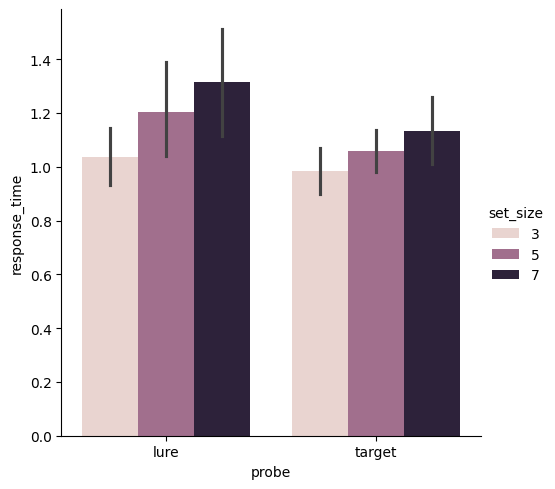

In [7]:
sns.catplot(
    rt, 
    x="probe", 
    y="response_time", 
    hue="set_size", 
    kind="bar",
    dodge=True,
)